In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')       
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class CustomKMeans(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

    def fit(self, X, y=None):
        X = np.array(X, dtype=float)
        rng = np.random.default_rng(self.random_state)
        random_idx = rng.choice(len(X), self.n_clusters, replace=False)
        self.cluster_centers_ = X[random_idx]

        for _ in range(self.max_iter):
            distances = self._compute_distances(X)
            labels = np.argmin(distances, axis=1)

            new_centers = np.array([
                X[labels == k].mean(axis=0) if np.any(labels == k)
                else self.cluster_centers_[k]
                for k in range(self.n_clusters)
            ])

            shift = np.linalg.norm(new_centers - self.cluster_centers_)
            self.cluster_centers_ = new_centers
            if shift < self.tol:
                break

        self.labels_ = labels
        return self

    def transform(self, X):
        X = np.array(X, dtype=float)
        return self._compute_distances(X)

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def predict(self, X):
        X = np.array(X, dtype=float)
        distances = self._compute_distances(X)
        return np.argmin(distances, axis=1)

    def _compute_distances(self, X):
        return np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

X = train_data.drop('label', axis=1)
y = train_data['label']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('kmeans', CustomKMeans(n_clusters=50, random_state=42)),
    ('log_reg', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline.fit(X, y)

cluster_labels = pipeline.named_steps['kmeans'].labels_
result = pd.DataFrame({'Actual_Label': y.values, 'Cluster_Label': cluster_labels})
print(result.groupby(['Cluster_Label', 'Actual_Label']).size())


d:\Compilers\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cluster_Label  Actual_Label
0              0                  1
               1               1194
               2                 62
               3                 11
               4                 28
                               ... 
49             3                114
               5                  8
               7                 20
               8                  2
               9                  5
Length: 376, dtype: int64


In [ ]:

X_features = pipeline[:-1].transform(X)  
y_labels = y


new_log_reg = LogisticRegression(max_iter=5000, random_state=42)


new_log_reg.fit(X_features, y_labels)


pipeline.named_steps['log_reg'] = new_log_reg


d:\Compilers\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
pipeline.score(X,y)

0.8878809523809523

d:\Compilers\Python311\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


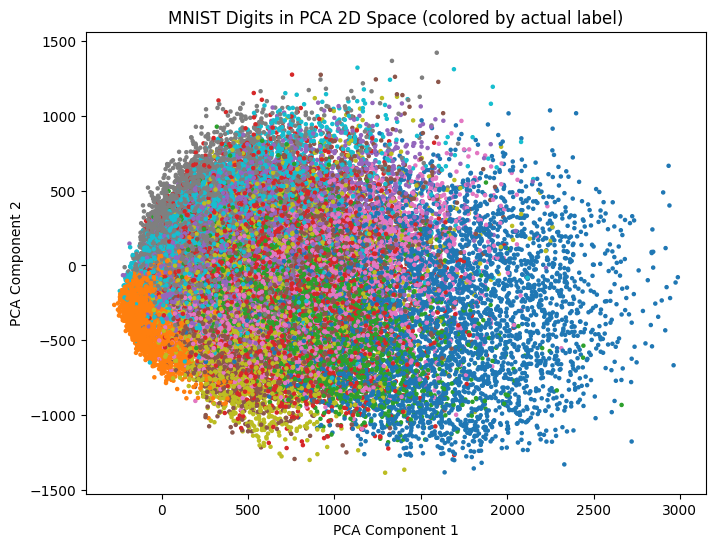

In [ ]:
import matplotlib.pyplot as plt

X_pca = pipeline.named_steps['pca'].transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=5)
plt.title("MNIST Digits in PCA 2D Space (colored by actual label)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


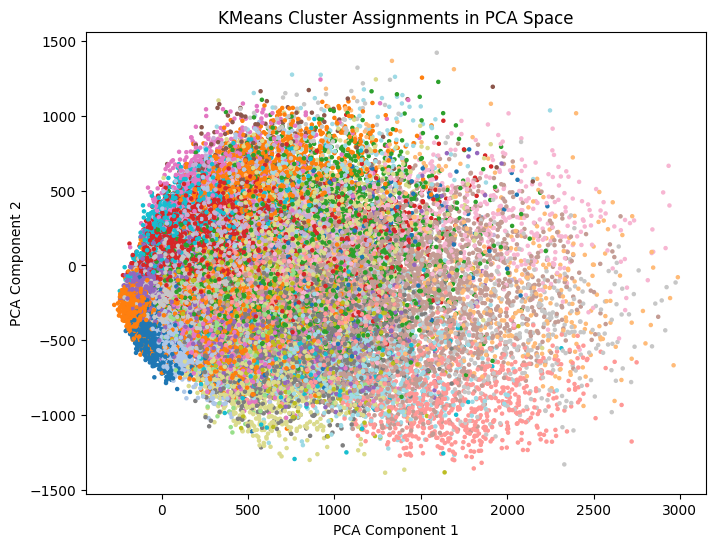

In [ ]:
cluster_labels = pipeline.named_steps['kmeans'].labels_

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab50', s=5)
plt.title("KMeans Cluster Assignments in PCA Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


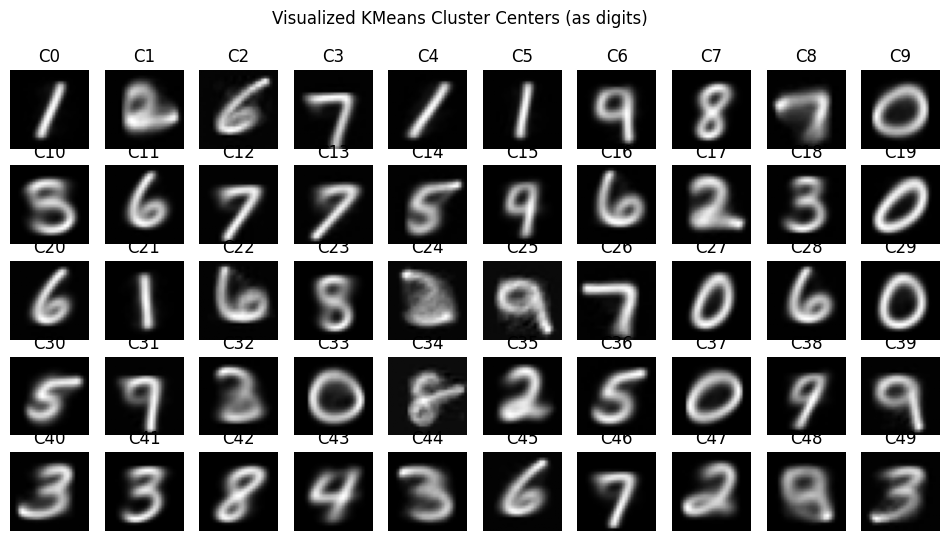

In [ ]:
import numpy as np

pca = pipeline.named_steps['pca']
scaler = pipeline.named_steps['scaler']
kmeans = pipeline.named_steps['kmeans']

cluster_centers_original = scaler.inverse_transform(
    pca.inverse_transform(kmeans.cluster_centers_)
)

fig, axes = plt.subplots(5, 10, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(cluster_centers_original[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'C{i}')
    ax.axis('off')

plt.suptitle("Visualized KMeans Cluster Centers (as digits)")
plt.show()


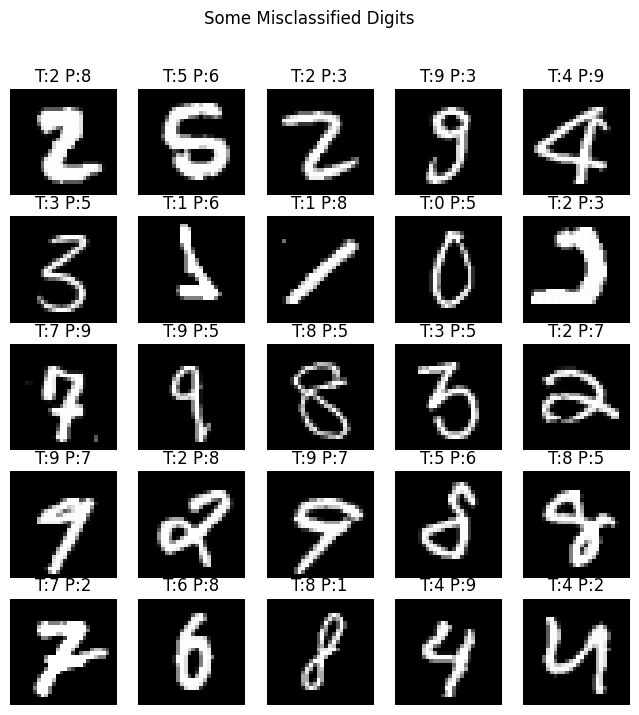

In [17]:
import numpy as np

y_pred = pipeline.predict(X)
mis_idx = np.where(y_pred != y)[0][:25]

fig, axes = plt.subplots(5, 5, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X.iloc[mis_idx[i]].values.reshape(28,28), cmap='gray')
    ax.set_title(f"T:{y.iloc[mis_idx[i]]} P:{y_pred[mis_idx[i]]}")
    ax.axis('off')

plt.suptitle("Some Misclassified Digits")
plt.show()


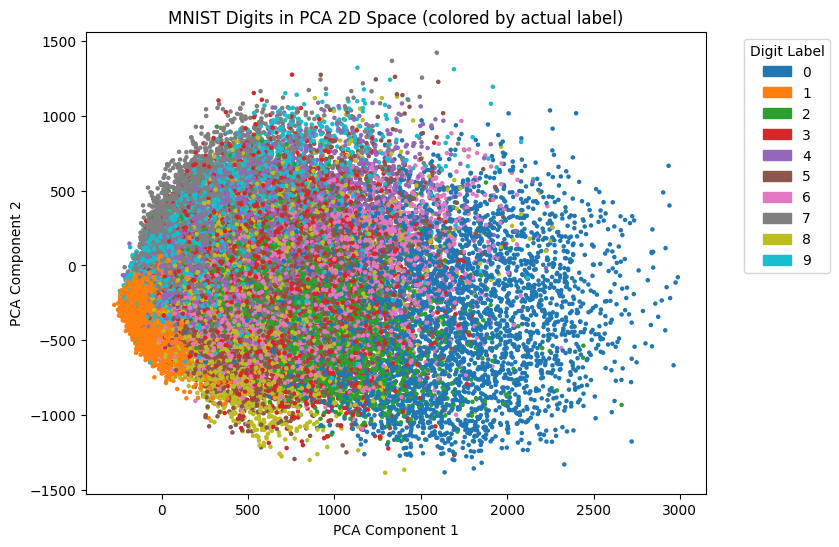

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', s=5)
plt.title("MNIST Digits in PCA 2D Space (colored by actual label)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=str(i)) for i in range(10)]
plt.legend(handles=handles, title="Digit Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
